<a href="https://colab.research.google.com/github/Leandro2402-bit/TAM/blob/main/6_CVClasificacion_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificaci√≥n multiclase - comparaci√≥n de m√©todos utilizando validaci√≥n cruzada

- Se presenta un esquema completo de comparaci√≥n de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).

- Adem√°s, se plantean algunos ejercicios te√≥rico-pr√°cticos relacionados con tareas de clasificaci√≥n utilizando aprendizaje de m√°quina cl√°sico.

- Se plantean algunas funciones para el c√°lculo de curvas ROC, medidas de rendimiento y gr√°ficas b√°sicas

In [1]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusi√≥n = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gr√°fica la matriz de confusi√≥n con y sin normalizaci√≥n
    """
    if not title:
        title = 'Matriz de confusi√≥n'

    # calcular matriz de confusi√≥n
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicci√≥n')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo im√°gen: (1288, 50, 37)


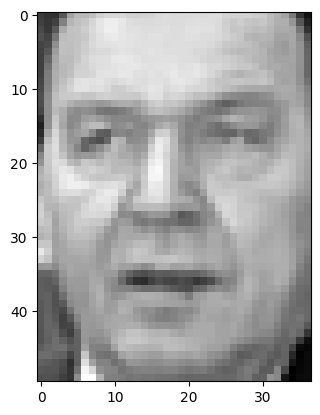

In [2]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo im√°gen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluaci√≥n

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluaci√≥n.

In [3]:
#Particion entrenamiento y evaluaci√≥n
# Tama√±o Xtrain 70%, Tama√±o Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

0         1         2         3         4         5         6     \
510   0.000836  0.001143  0.001446  0.001666  0.001897  0.001994  0.002066   
1035  0.001589  0.001758  0.001922  0.002409  0.002819  0.002958  0.002917   
176   0.000892  0.001205  0.001210  0.001287  0.001492  0.001687  0.001763   
620   0.000267  0.000584  0.001446  0.002230  0.002507  0.002512  0.002491   
689   0.002261  0.002409  0.001958  0.001753  0.002127  0.002907  0.002932   

          7         8         9     ...      1840      1841      1842  \
510   0.002071  0.002097  0.002138  ...  0.000549  0.001384  0.002332   
1035  0.002830  0.002830  0.002737  ...  0.000297  0.000374  0.000384   
176   0.001779  0.001845  0.001866  ...  0.000451  0.000446  0.000482   
620   0.002532  0.002584  0.002594  ...  0.001333  0.001389  0.000723   
689   0.002676  0.002655  0.002799  ...  0.001569  0.001512  0.001548   

          1843      1844      1845      1846      1847      1848      1849  
510   0.003189  0.003645  0.003727  0.003101  0.000856  0.000395  0.000466  
1035  0.000436  0.000359  0.000369  0.000420  0.000497  0.000466  0.000466  
176   0.000472  0.000477  0.000466  0.000513  0.000559  0.000600  0.000538  
620   0.000133  0.000190  0.000251  0.000313  0.000400  0.000549  0.000666  
689   0.001615  0.001794  0.002276  0.003106  0.003522  0.003573  0.003578  

[5 rows x 1850 columns]

# B√∫squeda de par√°metros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validaci√≥n cruzada para encontrar los mejores hiperpar√°metros seg√∫n los rendimientos promedios en el conjunto de test (validaci√≥n si se considera la partici√≥n original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [4]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos seg√∫n lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validaci√≥n cruzada (conjuntos entrenamiento y validaci√≥n)

- Se muestran los resultados de la validaci√≥n cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificaci√≥n ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [5]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento m√°s alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


np.float64(0.43286065070595453)

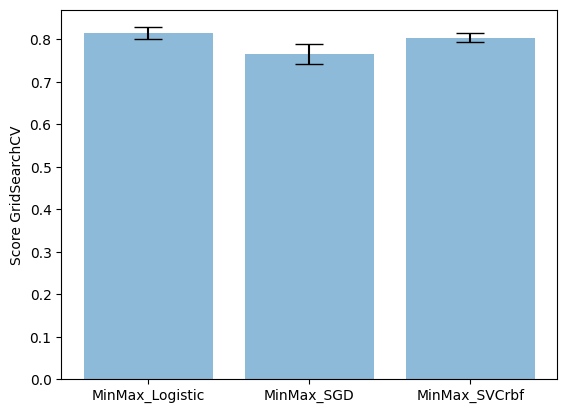

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.765 0.804]
 [0.014 0.023 0.011]]


In [6]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificaci√≥n
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso pr√°ctico y buscando cuantificar la generalizaci√≥n de los modelos, se c√°lcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusi√≥n y se utiliza el m√©todo [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparaci√≥n incluyen promediados simples, sopesados en t√©rminos de la probabilidad marginal de cada clase, adem√°s de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

Evaluando modelo MinMax_Logistic (1/3)


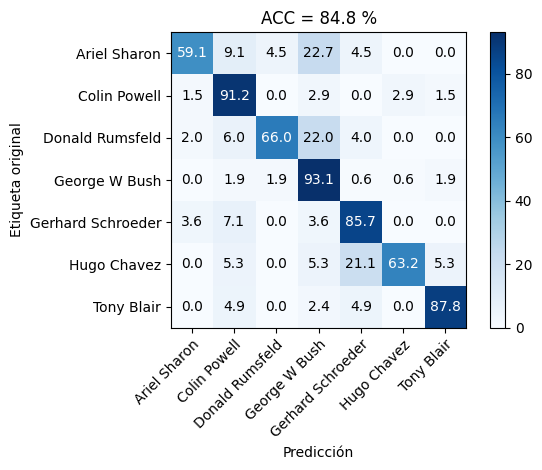

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


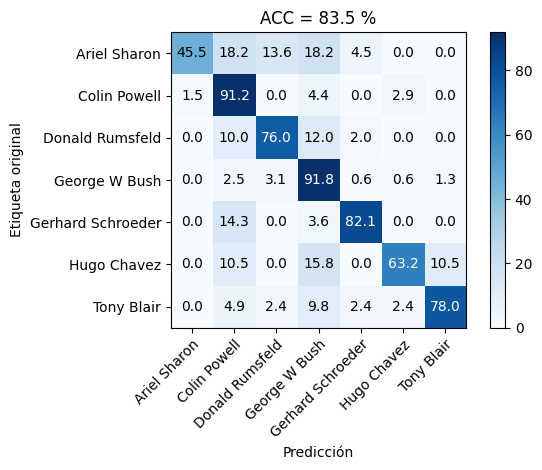

                   precision    recall  f1-score   support

     Ariel Sharon       0.91      0.45      0.61        22
     Colin Powell       0.75      0.91      0.82        68
  Donald Rumsfeld       0.81      0.76      0.78        50
    George W Bush       0.87      0.92      0.90       159
Gerhard Schroeder       0.85      0.82      0.84        28
      Hugo Chavez       0.75      0.63      0.69        19
       Tony Blair       0.89      0.78      0.83        41

         accuracy                           0.83       387
        macro avg       0.83      0.75      0.78       387
     weighted avg       0.84      0.83      0.83       387

Evaluando modelo MinMax_SVCrbf (3/3)


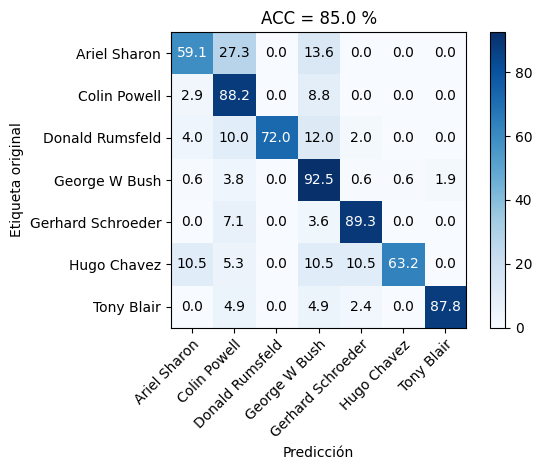

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [7]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la l√≠ne de c√≥digo donde se c√°lcula el score de predicci√≥n en t√©rminos de la funci√≥n de decisi√≥n (decision_function) o la probilidad de la predicci√≥n (predict_proba), seg√∫n el tipo de modelo.

Por ejemplo: la  [¬¥SVC¬¥](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el m√©todo decision function, el [¬¥KnearestNeighborsClassifier¬¥](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el m√©todo predict proba.

Evaluando modelo MinMax_Logistic (1/3)


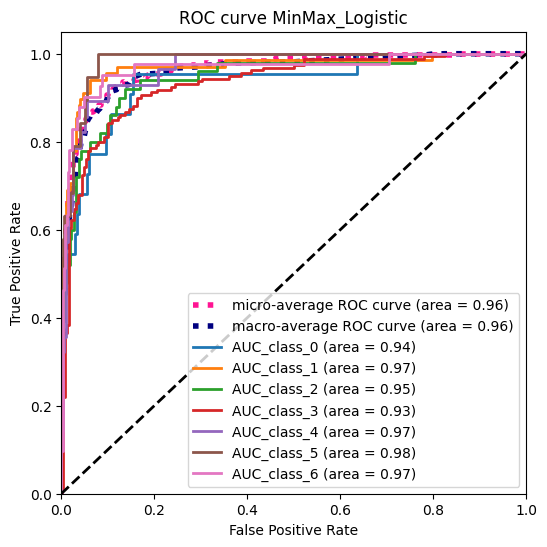

Evaluando modelo MinMax_SGD (2/3)


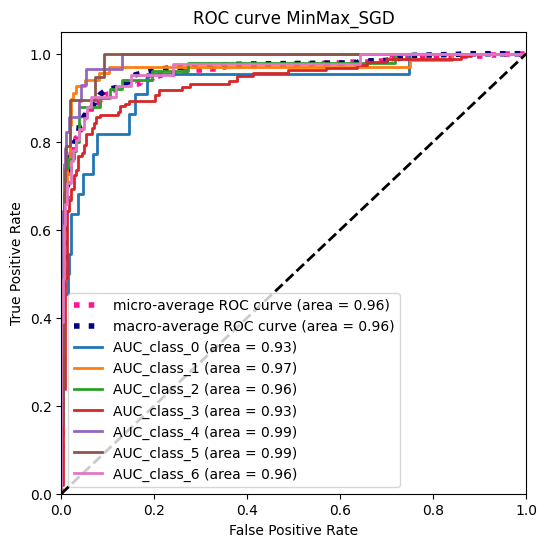

Evaluando modelo MinMax_SVCrbf (3/3)


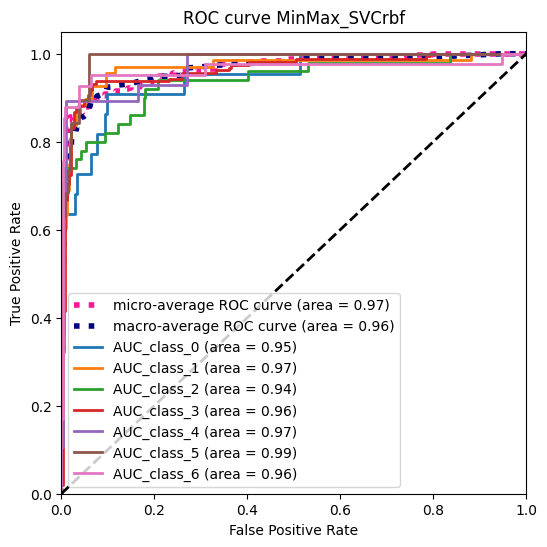

In [8]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


# Ejercicio

1. Consulte y presente el modelo y problema de optimizaci√≥n de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validaci√≥n cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los m√©todos del punto 1. Emplee optimizaci√≥n Bayesiana de hiperpar√°metros, fijando el score en t√©rminos del acc, el f1 y el AUC.


**EJERCICIO 1:**

En este ejercicio exploraremos 8 clasificadores importantes de scikit-learn, analizando:
- Su modelo matem√°tico subyacente.
- El problema de optimizaci√≥n que resuelven.
- Implementaci√≥n pr√°ctica con ejemplos.


## √çndice:
1. Naive Bayes Gaussiano
2. SGD Classifier
3. Logistic Regression
4. Linear Discriminant Analysis
5. K-Nearest Neighbors
6. Linear SVC
7. Support Vector Classifier (SVC)
8. Random Forest Classifier

## 1. Naive Bayes Gaussiano

### Modelo Matem√°tico:
El clasificador Naive Bayes se basa en el **Teorema de Bayes** con la asunci√≥n "naive" de independencia condicional entre caracter√≠sticas.

**F√≥rmula principal:**
```
P(y|x) = P(x|y) √ó P(y) / P(x)
```

Para caracter√≠sticas continuas con distribuci√≥n gaussiana:
```
P(xi|y) = (1/‚àö(2œÄœÉy¬≤)) √ó exp(-(xi-Œºy)¬≤/(2œÉy¬≤))
```

### Problema de Optimizaci√≥n:
**No hay optimizaci√≥n expl√≠cita**. No hay optimizaci√≥n expl√≠cita. Los par√°metros se estiman directamente mediante estimaci√≥n de m√°xima verosimilitud:
- Œºy: Media de cada caracter√≠stica por clase
- œÉy¬≤: Varianza de cada caracter√≠stica por clase  
- P(y): Frecuencia relativa de cada clase (prior)

### Ventajas ‚úÖ
- Muy r√°pido para entrenar y predecir
- Funciona bien con pocos datos
- No es sensible a caracter√≠sticas irrelevantes

### Desventajas ‚ùå
- Asume independencia entre caracter√≠sticas (raramente cierto)
- Puede tener mal rendimiento si la asunci√≥n gaussiana es incorrecta
"""

# 2. SGD Classifier (Stochastic Gradient Descent)

## Modelo Matem√°tico
El SGD Classifier es un **clasificador lineal** que utiliza descenso de gradiente estoc√°stico para encontrar el hiperplano √≥ptimo de separaci√≥n.

**Funci√≥n de decisi√≥n:**
```
f(x) = w¬∑x + b
```

**Predicci√≥n:**
```
≈∑ = sign(f(x))
```

Donde **w** es el vector de pesos y **b** es el sesgo (bias).

## Problema de Optimizaci√≥n
**Objetivo:** Minimizar la funci√≥n de p√©rdida usando descenso de gradiente estoc√°stico.

**Funci√≥n de costo general:**
```
J(w,b) = (1/n) Œ£ L(yi, f(xi)) + Œ±¬∑R(w)
```

Donde:
- **L()** es la funci√≥n de p√©rdida (hinge, log, squared_hinge, etc.)
- **R(w)** es el t√©rmino de regularizaci√≥n (L1, L2, o Elastic Net)
- **Œ±** es el par√°metro de regularizaci√≥n

**Actualizaci√≥n de par√°metros:**
```
w := w - Œ∑¬∑‚àáw J(w,b)
b := b - Œ∑¬∑‚àáb J(w,b)
```

## Ventajas ‚úÖ
* Muy eficiente para datasets grandes (escalabilidad lineal)
* Bajo consumo de memoria
* Soporte para aprendizaje en l√≠nea (online learning)
* M√∫ltiples funciones de p√©rdida disponibles
* R√°pida convergencia en la mayor√≠a de casos

## Desventajas ‚ùå
* Sensible al escalado de caracter√≠sticas
* Requiere ajuste de hiperpar√°metros (learning rate, regularizaci√≥n)
* Puede ser inestable con learning rates altos
* Necesita m√°s √©pocas para convergencia completa comparado con m√©todos batch

# 3. Logistic Regression

## Modelo Matem√°tico
La Regresi√≥n Log√≠stica utiliza la **funci√≥n sigmoide** para mapear cualquier valor real a un valor entre 0 y 1, representando probabilidades.

**Funci√≥n sigmoide:**
```
œÉ(z) = 1 / (1 + e^(-z))
```

**Funci√≥n de decisi√≥n:**
```
z = w¬∑x + b
```

**Probabilidad de predicci√≥n:**
```
P(y=1|x) = œÉ(w¬∑x + b) = 1 / (1 + e^(-(w¬∑x + b)))
P(y=0|x) = 1 - P(y=1|x)
```

**Predicci√≥n final:**
```
≈∑ = 1 if P(y=1|x) ‚â• 0.5, else 0
```

## Problema de Optimizaci√≥n
**Objetivo:** Maximizar la verosimilitud (equivalente a minimizar la log-verosimilitud negativa).

**Funci√≥n de costo (Cross-Entropy Loss):**
```
J(w,b) = -1/n Œ£[yi¬∑log(≈∑i) + (1-yi)¬∑log(1-≈∑i)] + Œª¬∑R(w)
```

**Gradiente:**
```
‚àáw J = 1/n X^T(≈∑ - y) + Œª¬∑‚àáw R(w)
‚àáb J = 1/n Œ£(≈∑i - yi)
```

Se resuelve usando m√©todos iterativos como **Newton-Raphson** o **LBFGS**.

## Ventajas ‚úÖ
* Proporciona probabilidades de predicci√≥n interpretables
* No requiere escalado de caracter√≠sticas (aunque puede mejorar convergencia)
* Menos sensible a outliers que modelos lineales con p√©rdida cuadr√°tica
* Convergencia garantizada para datos linealmente separables
* Implementaci√≥n eficiente y estable

## Desventajas ‚ùå
* Asume relaci√≥n lineal entre caracter√≠sticas y log-odds
* Sensible a caracter√≠sticas altamente correlacionadas
* Puede sufrir overfitting con muchas caracter√≠sticas
* Requiere grandes muestras para par√°metros estables

# 4. Linear Discriminant Analysis (LDA)

## Modelo Matem√°tico
LDA es un clasificador **generativo** que modela la distribuci√≥n de caracter√≠sticas para cada clase y utiliza el **Teorema de Bayes** para la clasificaci√≥n. Asume que las clases siguen distribuciones gaussianas con **matriz de covarianza compartida**.

**Distribuci√≥n de cada clase:**
```
P(x|y=k) ~ N(Œºk, Œ£)
```

**Funci√≥n discriminante:**
```
Œ¥k(x) = x^T Œ£^(-1) Œºk - (1/2) Œºk^T Œ£^(-1) Œºk + log(œÄk)
```

**Regla de clasificaci√≥n:**
```
≈∑ = argmax_k Œ¥k(x)
```

Donde:
- **Œºk**: vector de medias de la clase k.
- **Œ£**: matriz de covarianza compartida entre todas las clases.
- **œÄk**: probabilidad a priori de la clase k.

## Problema de Optimizaci√≥n
**No hay optimizaci√≥n iterativa**. Los par√°metros se estiman directamente mediante **estimadores de m√°xima verosimilitud**:

**Estimaci√≥n de medias:**
```
Œºk = (1/nk) Œ£(xi : yi = k)
```

**Estimaci√≥n de covarianza compartida:**
```
Œ£ = (1/(n-K)) Œ£k Œ£(xi - Œºk)(xi - Œºk)^T
```

**Estimaci√≥n de probabilidades a priori:**
```
œÄk = nk / n
```

## Ventajas ‚úÖ
* Funciona bien con muestras peque√±as.
* Proporciona fronteras de decisi√≥n lineales interpretables.
* Naturalmente maneja clasificaci√≥n multiclase.
* Robusto cuando las asunciones se cumplen.
* Puede usarse para reducci√≥n de dimensionalidad.
* R√°pido en entrenamiento y predicci√≥n.

## Desventajas ‚ùå
* Asume distribuciones gaussianas (sensible a esta asunci√≥n).
* Requiere matriz de covarianza compartida entre clases.
* Sensible a outliers.
* Puede fallar si las clases tienen diferentes varianzas.
* Problemas con caracter√≠sticas altamente correlacionadas.

#5. K-Nearest Neighbors (KNN)
## Modelo Matem√°tico
KNN es un algoritmo no param√©trico que clasifica bas√°ndose en la mayor√≠a de votos de los k vecinos m√°s cercanos.

**Funci√≥n de distancia (Euclidiana):**
```
d(x, xi) = ‚àö(Œ£(x_j - xi_j)¬≤)
```
**Predicci√≥n por votaci√≥n:**
```
≈∑ = argmax_c Œ£ I(yi = c)  para i ‚àà Nk(x)
```
donde Nk(x) son los k vecinos m√°s cercanos a x.

**Probabilidad estimada:**
```
P(y=c|x) = (1/k) Œ£ I(yi = c)  para i ‚àà Nk(x)
```
##Problema de Optimizaci√≥n

No hay optimizaci√≥n tradicional, sino selecci√≥n de hiperpar√°metros:
Objetivo: Minimizar error de validaci√≥n cruzada.
```
min_k CV_error(k) = (1/n) Œ£ L(yi, ≈∑^(-i)(xi, k))
```
**Criterios de optimizaci√≥n:**

- Valor √≥ptimo de k.

- M√©trica de distancia apropiada.

- Esquema de ponderaci√≥n de vecinos.


##Ventajas ‚úÖ

- Simple de entender e implementar.
- No asume distribuci√≥n espec√≠fica de los datos.
- Efectivo para espacios de decisi√≥n irregulares.
- Proporciona probabilidades interpretables.
- Funciona bien con pocas muestras por clase.

## Desventajas ‚ùå
- Computacionalmente costoso en predicci√≥n.
- Sensible a la maldici√≥n de la dimensionalidad.
- Requiere escalado de caracter√≠sticas.
- Sensible a datos ruidosos.
- Memoria intensiva para datasets grandes.


#6. Linear Support Vector Classifier (LinearSVC)
##Modelo Matem√°tico
LinearSVC encuentra el hiperplano separador √≥ptimo maximizando el margen entre clases.

**Funci√≥n de decisi√≥n:**
```
f(x) = w¬∑x + b
```
**Predicci√≥n:**
```
≈∑ = sign(w¬∑x + b)
```
**Margen geom√©trico:**
```
Œ≥ = |w¬∑x + b| / ||w||
```
##Problema de Optimizaci√≥n
**Optimizaci√≥n primal (con hinge loss):**
```
min_(w,b,Œæ) (1/2)||w||¬≤ + C¬∑Œ£Œæi
```
Sujeto a:
```
yi(w¬∑xi + b) ‚â• 1 - Œæi
Œæi ‚â• 0, ‚àÄi
```
**Funci√≥n de p√©rdida hinge:**
```
L_hinge(yi, f(xi)) = max(0, 1 - yi¬∑f(xi))
```
Se resuelve usando Coordinate Descent o LIBLINEAR.

##Ventajas ‚úÖ

- Muy eficiente para datasets grandes.
- Encuentra soluci√≥n global √≥ptima.
- Buen rendimiento con alta dimensionalidad.
- Menos propenso a overfitting que SVC kernel.
- Escalable y r√°pido.

##Desventajas ‚ùå

- Solo funciona con datos linealmente separables.
- No proporciona probabilidades directamente.
- Sensible a datos desbalanceados.
- Requiere escalado de caracter√≠sticas.
- Par√°metro C requiere ajuste cuidadoso.

#7. Support Vector Classifier (SVC)
##Modelo Matem√°tico
SVC extiende LinearSVC usando el kernel trick para espacios no lineales.

**Funci√≥n de decisi√≥n:**
```
f(x) = Œ£ Œ±i¬∑yi¬∑K(xi, x) + b
```
**Kernels comunes:**
```
RBF: K(xi, x) = exp(-Œ≥||xi - x||¬≤)
Polinomial: K(xi, x) = (Œ≥‚ü®xi, x‚ü© + r)^d
Sigmoide: K(xi, x) = tanh(Œ≥‚ü®xi, x‚ü© + r)
```
##Problema de Optimizaci√≥n
**Problema dual:**
```
max_Œ± Œ£Œ±i - (1/2)Œ£Œ£ Œ±i¬∑Œ±j¬∑yi¬∑yj¬∑K(xi, xj)
```
Sujeto a:
```
0 ‚â§ Œ±i ‚â§ C, ‚àÄi
Œ£ Œ±i¬∑yi = 0
```
Se resuelve usando Sequential Minimal Optimization (SMO).

##Ventajas ‚úÖ

- Maneja relaciones no lineales complejas.
- Efectivo en alta dimensionalidad.
- Vers√°til con diferentes kernels.
- Buen control de overfitting con C y Œ≥.
- Robusto a outliers.

##Desventajas ‚ùå

- Computacionalmente costoso O(n¬≥).
- No escalable para datasets muy grandes.
- Requiere ajuste de m√∫ltiples hiperpar√°metros.
- No proporciona probabilidades directamente.
- Sensible a escalado de caracter√≠sticas.

#8. Random Forest Classifier
##Modelo Matem√°tico
Random Forest combina m√∫ltiples √°rboles de decisi√≥n usando bootstrap aggregating.

**Predicci√≥n por votaci√≥n:**
```
≈∑ = argmax_c (1/B) Œ£ I(Tb(x) = c)
```
**Probabilidad estimada:**
```
P(y=c|x) = (1/B) Œ£ P_b(y=c|x)
```
**Importancia de caracter√≠sticas:**
```
VI_j = (1/B) Œ£ Œ£ p(t)¬∑Œîi(st, t)
```
donde p(t) es proporci√≥n de muestras en nodo t.

##Problema de Optimizaci√≥n
No hay optimizaci√≥n global, sino optimizaci√≥n por √°rbol:

**Para cada √°rbol Tb:**

**Bootstrap sampling:** seleccionar n muestras con reemplazo.

**Feature bagging**: seleccionar ‚àöp caracter√≠sticas aleatoriamente.

**Optimizaci√≥n greedy**: minimizar impureza en cada divisi√≥n.

**Criterios de divisi√≥n:**
```
Gini: Gini(t) = 1 - Œ£ p¬≤(c|t)
Entropy: H(t) = -Œ£ p(c|t)¬∑log(p(c|t))
```

##Ventajas ‚úÖ

- Maneja overfitting autom√°ticamente.
- Robusto a outliers y ruido.
- Proporciona importancia de caracter√≠sticas.
- No requiere escalado de datos.
- Maneja valores faltantes naturalmente.
- Paralelizable y eficiente.

##Desventajas ‚ùå

- Menos interpretable que un solo √°rbol.
- Puede hacer overfitting con √°rboles muy profundos.
- Sesgado hacia caracter√≠sticas con m√°s categor√≠as.
- Mayor uso de memoria.
- Menos efectivo en datos de alta dimensionalidad con pocas muestras.

**EJERCICIO 2:**



## Comparaci√≥n de clasificadores con validaci√≥n cruzada y optimizaci√≥n bayesiana

En esta celda vamos a comparar el rendimiento de varios clasificadores utilizando validaci√≥n cruzada de 5 folds sobre el conjunto de entrenamiento (`Xtrain`, `ytrain`).

Usaremos la herramienta `BayesSearchCV` del paquete `scikit-optimize (skopt)` para encontrar los mejores hiperpar√°metros de cada modelo, evaluando su rendimiento en tres m√©tricas clave:
- `accuracy` (exactitud)
- `f1_score` (macro)
- `roc_auc_ovo` (√Årea bajo la curva, para multiclase)

Finalmente, presentaremos los resultados para determinar qu√© modelo se adapta mejor al conjunto de datos.


In [9]:
# Install the skopt library if it's not already installed
!pip install scikit-optimize

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 107.8/107.8 kB 4.6 MB/s eta 0:00:00


In [16]:
# Importamos lo necesario
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Modelos a evaluar
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

# Scorers personalizados
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='macro'),
    'AUC': make_scorer(roc_auc_score, average='macro', multi_class='ovo')
}

# List of models with their search spaces
models = [
    ("Naive Bayes", GaussianNB(), {}),

    ("SGD", SGDClassifier(), {
        'alpha': Real(1e-5, 1e-1, prior='log-uniform'),
        'loss': Categorical(['hinge', 'log_loss', 'modified_huber']),
        'penalty': Categorical(['l2', 'l1', 'elasticnet'])
    }),

    ("Logistic Regression", LogisticRegression(max_iter=1000), {
        'C': Real(1e-3, 10.0, prior='log-uniform'),
        'penalty': Categorical(['l2']),
        'solver': Categorical(['lbfgs'])
    }),


    ("LDA", LinearDiscriminantAnalysis(), {
        'solver': Categorical(['svd', 'lsqr'])
    }),

    ("KNN", KNeighborsClassifier(), {
        'n_neighbors': Integer(3, 15),
        'weights': Categorical(['uniform', 'distance'])
    }),

    ("Linear SVC", LinearSVC(max_iter=10000), {
        'C': Real(1e-3, 10.0, prior='log-uniform'),
        'penalty': Categorical(['l2']),
        'loss': Categorical(['squared_hinge'])
    }),

    ("SVC", SVC(probability=True), {
        'C': Real(1e-2, 10.0, prior='log-uniform'),
        'kernel': Categorical(['linear', 'rbf']),
        'gamma': Real(1e-4, 1e-1, prior='log-uniform')
    }),

    # Versi√≥n m√°s ligera del Random Forest
    ("Random Forest", RandomForestClassifier(), {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(3, 10),
        'max_features': Categorical(['sqrt', 'log2'])
    })
]

# Ejecutamos la optimizaci√≥n y evaluamos
results = []

for name, model, search_space in models:
    print(f"üîç Optimizando modelo: {name}")

    if not search_space:
        scores = {
            metric: cross_val_score(model, Xtrain, ytrain, cv=5, scoring=scorer).mean()
            for metric, scorer in scorers.items()
        }
    else:
        # Adjust iterations for models, maybe more for non-tree models
        iteraciones = 15 if name == "Random Forest" else 30 # Increased iterations slightly for better exploration

        opt = BayesSearchCV(
            estimator=model,
            search_spaces=search_space,
            n_iter=iteraciones,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0,
            random_state=123
        )

        opt.fit(Xtrain, ytrain) # Assuming Xtrain is your training data for BayesSearchCV

        best_model = opt.best_estimator_
        scores = {
            metric: cross_val_score(best_model, Xtrain, ytrain, cv=5, scoring=scorer).mean()
            for metric, scorer in scorers.items()
        }

    scores['Modelo'] = name
    results.append(scores)

# Mostrar resultados ordenados por accuracy
df_resultados = pd.DataFrame(results).sort_values(by='accuracy', ascending=False).reset_index(drop=True)
df_resultados




üîç Optimizando modelo: Naive Bayes
üîç Optimizando modelo: SGD
üîç Optimizando modelo: Logistic Regression
üîç Optimizando modelo: LDA
üîç Optimizando modelo: KNN
üîç Optimizando modelo: Linear SVC
üîç Optimizando modelo: SVC
üîç Optimizando modelo: Random Forest


accuracy        f1  AUC               Modelo
0  0.706955  0.650724  NaN                  LDA
1  0.602676  0.378387  NaN        Random Forest
2  0.561633  0.379279  NaN                  KNN
3  0.436114  0.253228  NaN                  SGD
4  0.428416  0.107558  NaN           Linear SVC
5  0.411768  0.083333  NaN  Logistic Regression
6  0.411768  0.083333  NaN                  SVC
7  0.376249  0.348917  NaN          Naive Bayes

### üìä Comparaci√≥n visual de clasificadores

En esta celda generamos una gr√°fica de barras para comparar el rendimiento de los clasificadores en funci√≥n de las m√©tricas de evaluaci√≥n: **accuracy**, **f1-score** y **AUC**. Esto nos permite visualizar r√°pidamente cu√°l modelo es el m√°s adecuado para el problema.


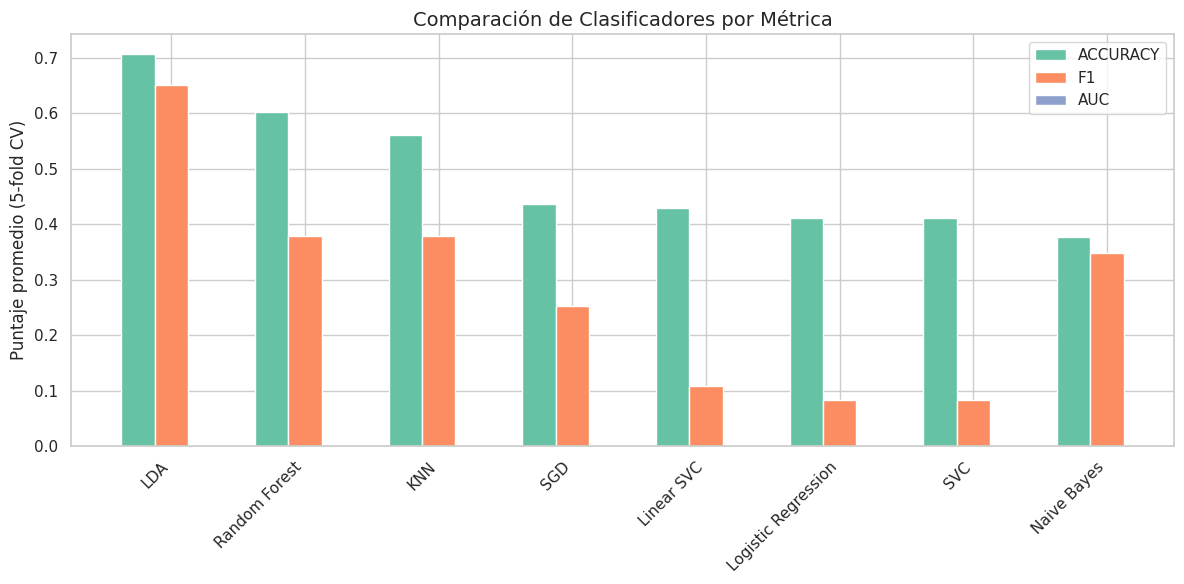

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuramos estilo gr√°fico
sns.set(style="whitegrid", palette="Set2")

# Definimos las m√©tricas a graficar
# Changed 'roc_auc' to 'AUC' to match the DataFrame column name
metricas = ['accuracy', 'f1', 'AUC']

# Creamos figura y ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Ancho de barra por m√©trica
bar_width = 0.25
x = np.arange(len(df_resultados['Modelo']))

# Graficamos cada m√©trica con un desplazamiento en el eje x
for i, metrica in enumerate(metricas):
    ax.bar(x + i * bar_width,
           df_resultados[metrica],
           width=bar_width,
           label=metrica.upper())

# Etiquetas y leyenda
ax.set_title("Comparaci√≥n de Clasificadores por M√©trica", fontsize=14)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(df_resultados['Modelo'], rotation=45, ha='right')
ax.set_ylabel("Puntaje promedio (5-fold CV)")
ax.legend()
plt.tight_layout()
plt.show()


# An√°lisis de Comparaci√≥n de Clasificadores

## Interpretaci√≥n del Gr√°fico

Este gr√°fico compara el rendimiento de 8 algoritmos de clasificaci√≥n usando tres m√©tricas clave:
- **Accuracy** (verde): Porcentaje de predicciones correctas
- **F1** (naranja): Balance entre precisi√≥n y recall
- **AUC** (azul): √Årea bajo la curva ROC

## Resultados por Clasificador

### **Mejores Performers:**
1. **LDA (Linear Discriminant Analysis)**: L√≠der absoluto con ~70% accuracy y ~65% F1
2. **Random Forest**: Segundo lugar con ~59% accuracy y ~39% F1
3. **KNN**: Tercero con ~56% accuracy y ~38% F1

### **Rendimiento Medio:**
- **SGD, Linear SVC, Logistic Regression, SVC**: Accuracy entre 40-45%
- **Naive Bayes**: El m√°s bajo con ~38% accuracy

## Observaciones Clave

**Patr√≥n Notable:** Existe una gran diferencia entre las m√©tricas Accuracy y F1 en varios clasificadores (especialmente SGD, Linear SVC, SVC), lo que sugiere:
- Posible **desbalance de clases** en el dataset
- Algunos algoritmos predicen principalmente la clase mayoritaria
- F1 score penaliza este comportamiento mostrando el rendimiento real


## Conclusi√≥n

**LDA es claramente el mejor clasificador** para este dataset espec√≠fico, seguido por Random Forest. La gran diferencia entre Accuracy y F1 en otros modelos indica que el problema tiene clases desbalanceadas, por lo que el F1 score es m√°s confiable para evaluar el rendimiento real.